# Imports

In [20]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils, optimizers
from PIL import Image
import shutil
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow import convert_to_tensor
import matplotlib.image as mpimg
import pickle

# Create DataFrame

In [21]:
#These variables can be changes, excluding train_dir
train_dir = "../raw_data/Training"
img_height, img_width = 256, 256
batch_size = 32
poses = sorted(os.listdir("../raw_data/Training"))

In [22]:
poses

['.ipynb_checkpoints',
 'Boat_Pose_or_Paripurna_Navasana_',
 'Bound_Angle_Pose',
 'Bow_Pose_or_Dhanurasana_',
 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_',
 'Camel_Pose_or_Ustrasana_',
 'Cat_Cow_Pose_or_Marjaryasana_',
 'Chair_Pose_or_Utkatasana_',
 'Child_Pose',
 'Cobra_Pose_or_Bhujangasana_',
 'Cockerel_Pose',
 'Corpse_Pose_or_Savasana_',
 'Cow_Face_Pose_or_Gomukhasana_',
 'Crane_(Crow)_Pose',
 'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_',
 'Dolphin_Pose',
 'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_',
 'Eagle_Pose_or_Garudasana_',
 'Easy_pose_or_sukhasana',
 'Eight-Angle_Pose_or_Astavakrasana_',
 'Extended_Puppy_Pose_or_Uttana_Shishosana_',
 'Extended_Revolved_Side_Angle_Pose',
 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_',
 'Feathered_Peacock_Pose_or_Pincha_Mayurasana_',
 'Firefly_Pose_or_Tittibhasana_',
 'Fish_Pose_or_Matsyasana_',
 'Four-Limbed_Staff',
 'Frog_Pose_or_Bhekasana',
 'Garland_Pose_or_Malasana_',
 'Gate_Pose_or_Parighasana_',
 'Half_Lord_of_

In [23]:
#Splits into train_generator and validation_generator
#This bulk uploads the images
#Creates target (y) for us!

#Play around with the interpolation argument - bicubic, lanczos??? 

train_datagen = ImageDataGenerator(rescale=1./255,
                                    vertical_flip=True,
                                    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                    train_dir,
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='training',
                                    keep_aspect_ratio=True,
                                    interpolation='lanczos') # set as training data

validation_generator = train_datagen.flow_from_directory(
                                    train_dir, # same directory as training data
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='validation',
                                    keep_aspect_ratio=True,
                                    interpolation='lanczos') # set as validation data

Found 11671 images belonging to 87 classes.
Found 2878 images belonging to 87 classes.


# Model

In [24]:
...
# Model needs building + transfer learning  
...
def initialize_model():
    base_model = densenet.DenseNet169(
                        include_top=False,
                        weights='imagenet',
                        input_shape=(img_height, img_width, 3),
                        classifier_activation='softmax')
    
    base_model.trainable = True

    model = models.Sequential([ 
        base_model,
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1000,activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(900, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(800, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(700, activation="relu"),
        layers.Dense(87, activation="softmax")
    ])
    
    
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
    return model

In [25]:
model = initialize_model()

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 8, 8, 1664)        12642880  
                                                                 
 flatten_2 (Flatten)         (None, 106496)            0         
                                                                 
 dropout_8 (Dropout)         (None, 106496)            0         
                                                                 
 dense_10 (Dense)            (None, 1000)              106497000 
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 dense_11 (Dense)            (None, 900)               900900    
                                                                 
 dropout_10 (Dropout)        (None, 900)              

In [27]:
es = EarlyStopping(patience=5, restore_best_weights=True)

In [28]:
#fit model - fit on train_generator (both X and y) and the validation data is validation_generator
history = model.fit(
                train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size,
                epochs=500,
                callbacks=[es])

Epoch 1/500
364/364 [==============================] - 372s 818ms/step - loss: 4.3172 - accuracy: 0.0466 - val_loss: 3.7182 - val_accuracy: 0.1243
Epoch 2/500
364/364 [==============================] - 289s 794ms/step - loss: 3.4454 - accuracy: 0.1411 - val_loss: 2.7337 - val_accuracy: 0.2872
Epoch 3/500
364/364 [==============================] - 282s 773ms/step - loss: 2.6114 - accuracy: 0.3010 - val_loss: 2.0178 - val_accuracy: 0.4386
Epoch 4/500
364/364 [==============================] - 284s 779ms/step - loss: 2.0419 - accuracy: 0.4283 - val_loss: 1.6525 - val_accuracy: 0.5390
Epoch 5/500
364/364 [==============================] - 289s 792ms/step - loss: 1.6777 - accuracy: 0.5117 - val_loss: 1.5140 - val_accuracy: 0.5787
Epoch 6/500
364/364 [==============================] - 295s 810ms/step - loss: 1.4423 - accuracy: 0.5807 - val_loss: 1.4016 - val_accuracy: 0.6081
Epoch 7/500
364/364 [==============================] - 295s 809ms/step - loss: 1.2472 - accuracy: 0.6309 - val_loss: 1

In [27]:
history.history

{'loss': [4.004055500030518,
  2.7326788902282715,
  1.9306105375289917,
  1.4648991823196411,
  1.1824712753295898,
  0.9777507781982422],
 'accuracy': [0.09797822684049606,
  0.30596163868904114,
  0.47662001848220825,
  0.5888025164604187,
  0.6607568860054016,
  0.7120788097381592],
 'val_loss': [2.972832441329956,
  2.0567378997802734,
  1.591464877128601,
  1.4398857355117798,
  1.2371796369552612,
  1.2974331378936768],
 'val_accuracy': [0.26309120655059814,
  0.4607263505458832,
  0.5633445978164673,
  0.6081081032752991,
  0.6710304021835327,
  0.6617398858070374]}

In [100]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
model.save_weights('../saved_models/my_checkpoint')

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

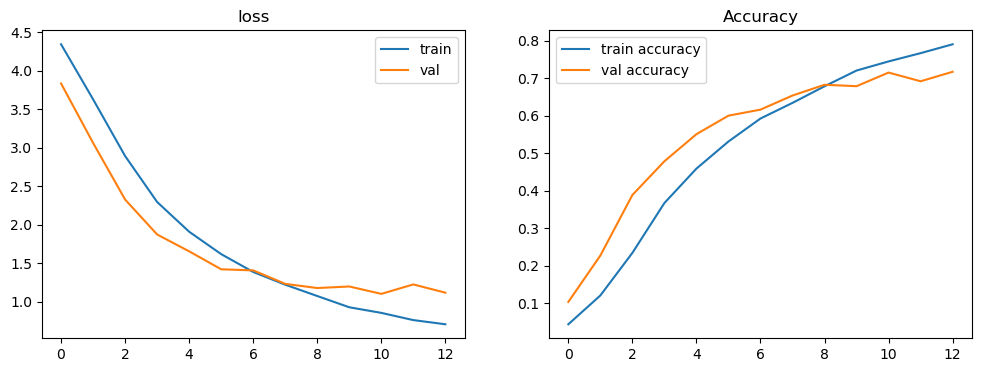

In [101]:
plot_history(history)

# Prediction

In [29]:
test_dir = "../test"

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255) # set validation split

test_generator = test_datagen.flow_from_directory(
                                    test_dir,
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='training',
                                    keep_aspect_ratio=True,
                                    interpolation='bicubic') # set as training data

Found 1 images belonging to 2 classes.


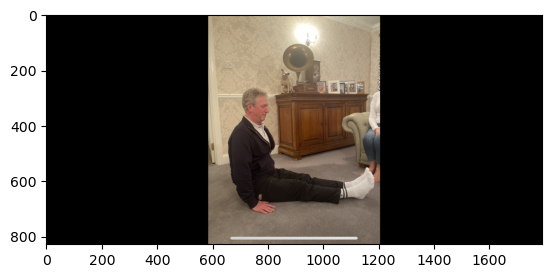

In [47]:
plt.imshow(mpimg.imread("../test/test/IMG_5553.jpg"))

In [49]:
prediction = poses[np.argmax(model.predict(test_generator))]
prediction

1/1 [==============================] - 0s 75ms/step


'Staff_Pose_'

In [33]:
prediction = poses[np.argmax(model.predict(test_generator))]
photo_path = f"../ground_truth/{prediction}.jpeg"
fig = plt.imshow(mpimg.imread(photo_path))
plt.title(prediction)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

1/1 [==============================] - 7s 7s/step


FileNotFoundError: [Errno 2] No such file or directory: '../ground_truth/Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_.jpeg'

# Test

In [51]:
test_dir = "../raw_data/Testing"

In [52]:
test_datagen = ImageDataGenerator(rescale=1./255) # set validation split

test_generator = test_datagen.flow_from_directory(
                                    test_dir,
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    subset='training',
                                    keep_aspect_ratio=True,
                                    interpolation='bicubic') # set as training data

Found 6287 images belonging to 87 classes.


In [53]:
model.evaluate(test_generator)

  6/197 [..............................] - ETA: 3:59 - loss: 1.1125 - accuracy: 0.7240

/opt/conda/envs/python3106/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


197/197 [==============================] - 232s 1s/step - loss: 1.0345 - accuracy: 0.7395


[1.0344842672348022, 0.7394623756408691]

# Probabilities

In [ ]:
df = pd.DataFrame(poses)
df["probability"] = model.predict(test_generator)[0]

In [ ]:
df[df[0]=="Sitting_pose_1_(normal)"]

# Save models

In [50]:
with open("../saved_models/model_4.pkl", "wb") as file:
    pickle.dump(model, file)



Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_100
...............vars
............activation_101
...............vars
............activation_102
...............vars
............activation_103
...............vars
............activation_104
...............vars
............activation_105
...............vars
............activation_106
...............vars
....

In [4]:
model = pickle.load(open("../saved_models/model_1.pkl","rb"))

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-10 16:24:24           64
config.json                                    2023-03-10 16:24:24       283448
variables.h5                                   2023-03-10 16:24:28    486988968


2023-03-11 08:22:42.992272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 08:22:44.546734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 08:22:44.548875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 08:22:44.576212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_100
...............vars
............activation_101
...............vars
............activation_102
...............vars
............activation_103
...............vars
............activation_104
...............vars
............activation_105
...............vars
............activation_106
...............vars
....